In [ ]:
#!pip install tf-models-official

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 19.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 27.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 50.6 MB/s eta 0:00:00
  C

In [ ]:
from google.colab import auth
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import os
from sklearn.decomposition import PCA
import os
from google.cloud import storage
import glob
from typing import Iterable
import functools
from typing import Dict, List, Optional, Tuple

import tensorflow_models as tfm


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
auth.authenticate_user()

In [ ]:
!unzip /content/embeds.zip

Streaming output truncated to the last 5000 lines.
  inflating: content/mimic-embeddings-files/aa76dd80-366ce0f8-128fb9a5-f5f7c3b7-4638c12d.tfrecord  
  inflating: content/mimic-embeddings-files/78dae879-3c81c691-4490adfb-5bf59542-67e7aecd.tfrecord  
  inflating: content/mimic-embeddings-files/8908ed67-dfe3a344-b8b6a018-d22c9013-0f81dcfa.tfrecord  
  inflating: content/mimic-embeddings-files/c1910c41-1be8276f-a558769e-1df36a8b-700c162d.tfrecord  
  inflating: content/mimic-embeddings-files/fbaeb3a9-7c40bd89-a95d726a-d8418686-85e8ee18.tfrecord  
  inflating: content/mimic-embeddings-files/9deba41b-35543479-34d169fe-51ba4f21-e938c83f.tfrecord  
  inflating: content/mimic-embeddings-files/ce362fe3-6f241715-574e46e8-4b03eb14-e852d034.tfrecord  
  inflating: content/mimic-embeddings-files/09403de0-116022ff-321e8988-3d37a605-3f789c56.tfrecord  
  inflating: content/mimic-embeddings-files/c6ef8b77-cd3b99b5-a9c7af51-8af80250-6c9fbe65.tfrecord  
  inflating: content/mimic-embeddings-files/4ef38

In [ ]:
df_labels = pd.read_csv('/content/data-fin')
df_labels = df_labels.drop(columns=['Unnamed: 0'])
df_labels.head(1)

,embedding_file,subject_id,study_id,dicom_id,insurance,race,label,gender
0,files/p10/p10000980/s50985099/6ad03ed1-97ee17e...,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,1.0,BLACK,0,F


In [ ]:
# merge on study_id with mimic-cxr-2.0.0-chexpert.csv.gz and mimic-cxr-2.0.0-negbio.csv.gz files of support devices

In [ ]:
# train - test splits
ids = df_labels['subject_id'].unique()
np.random.shuffle(ids)
train_ids = set(ids[:int(.8*len(ids))])
test_ids = set(ids[int(.8*len(ids)):])

In [ ]:
df_labels['split'] = df_labels['subject_id'].apply(lambda x: 'train' if x in train_ids else 'validate')
df_labels

,embedding_file,subject_id,study_id,dicom_id,insurance,race,label,gender,split
0,files/p10/p10000980/s50985099/6ad03ed1-97ee17e...,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,1.0,BLACK,0,F,train
1,files/p10/p10000980/s51967283/943486a3-b3fa9ff...,10000980,51967283,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,1.0,BLACK,0,F,train
2,files/p10/p10000980/s54577367/cfb03587-782edf6...,10000980,54577367,cfb03587-782edf6c-1bf392e1-98196cd5-365d69e8,1.0,BLACK,0,F,train
3,files/p10/p10000980/s54935705/6ad819bb-bae74eb...,10000980,54935705,6ad819bb-bae74eb9-7b663e90-b8deabd7-57f8054a,1.0,BLACK,0,F,train
4,files/p10/p10000980/s54980801/a75a1fbe-802065a...,10000980,54980801,a75a1fbe-802065ad-717eb7c1-e2ce3552-646276a6,1.0,BLACK,0,F,train
...,...,...,...,...,...,...,...,...,...
23002,files/p13/p13196638/s51956967/76947f29-410884d...,13196638,51956967,76947f29-410884d3-57ee9c25-f4781392-95ecd2e4,1.0,WHITE / CAUCASION,1,M,train
23003,files/p13/p13196638/s51956967/dc2f1215-d41959a...,13196638,51956967,dc2f1215-d41959af-0b4f5ae9-fd4480df-4d64625a,1.0,WHITE / CAUCASION,1,M,train
23004,files/p13/p13196638/s58056254/7f5a1c4f-4a9666e...,13196638,58056254,7f5a1c4f-4a9666ec-66008f60-16871c71-e69c0247,1.0,WHITE / CAUCASION,1,M,train
23005,files/p13/p13196638/s59401220/5dc626b5-c12038f...,13196638,59401220,5dc626b5-c12038f9-b5dea539-bfa56660-97787cef,1.0,WHITE / CAUCASION,1,M,train


In [ ]:
# Choose some of the Chexpert generated diagnoses
for diagnosis in ('label', 'insurance', 'race', 'gender'):
  # Remove missing/unsure labels
  df = df_labels[df_labels[diagnosis].isin((0, 1))]
  # Only need diagnosis, image_id, and train/test/val split for ML model
  df = df[[diagnosis, 'dicom_id', 'embedding_file', 'split']]
  # Workaround for: https://github.com/Google-Health/imaging-research/issues/7
  # You don't need to do this if not using train_lib.py
  df['image_id'] = df['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")
  df.to_csv(f'{diagnosis}.csv', index=False)
  print(f"Created {diagnosis}.csv with {len(df)} rows")
  display(df.nunique())
  # Show label and split value distributions
  display(df[diagnosis].value_counts())
  display(df['split'].value_counts())
  print("\n")

Created label.csv with 23007 rows


label                 2
dicom_id          23007
embedding_file    23007
split                 2
image_id          23007
dtype: int64

1    13049
0     9958
Name: label, dtype: int64

train       18031
validate     4976
Name: split, dtype: int64



Created insurance.csv with 23007 rows


insurance             2
dicom_id          23007
embedding_file    23007
split                 2
image_id          23007
dtype: int64

1.0    17649
0.0     5358
Name: insurance, dtype: int64

train       18031
validate     4976
Name: split, dtype: int64



Created race.csv with 0 rows


race              0
dicom_id          0
embedding_file    0
split             0
image_id          0
dtype: int64

Series([], Name: race, dtype: int64)

Series([], Name: split, dtype: int64)



Created gender.csv with 0 rows


gender            0
dicom_id          0
embedding_file    0
split             0
image_id          0
dtype: int64

Series([], Name: gender, dtype: int64)

Series([], Name: split, dtype: int64)

In [ ]:
# label insurance race gender
DIAGNOSIS = 'label'
LABELS_CSV = f"{DIAGNOSIS}.csv"

# Download the embeddings files here
EMBEDDINGS_DIR = 'mimic-embeddings-files'

if not os.path.exists(EMBEDDINGS_DIR):
  os.mkdir(EMBEDDINGS_DIR)

df = pd.read_csv(LABELS_CSV)
df.head()

,label,dicom_id,embedding_file,split,image_id
0,0,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,files/p10/p10000980/s50985099/6ad03ed1-97ee17e...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...
1,0,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,files/p10/p10000980/s51967283/943486a3-b3fa9ff...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...
2,0,cfb03587-782edf6c-1bf392e1-98196cd5-365d69e8,files/p10/p10000980/s54577367/cfb03587-782edf6...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...
3,0,6ad819bb-bae74eb9-7b663e90-b8deabd7-57f8054a,files/p10/p10000980/s54935705/6ad819bb-bae74eb...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...
4,0,a75a1fbe-802065ad-717eb7c1-e2ce3552-646276a6,files/p10/p10000980/s54980801/a75a1fbe-802065a...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...


In [ ]:
def download_blob(bucket, source_blob_name: str, destination_file_name: str):
    """
    Downloads a blob from the bucket.

    https://cloud.google.com/storage/docs/downloading-objects
    """
    blob = bucket.blob(source_blob_name)
    try:
      blob.download_to_filename(destination_file_name)
    except Exception as e:
      print('Error during download - do you have the right permissions?')
      print(e)
      return
    print(f"Downloaded {source_blob_name}")


storage_client = storage.Client()

embeddings_bucket = storage_client.bucket(
    'image-embeddings-mimic-cxr-1.0.physionet.org')

In [ ]:
'''# Download training files
for i, row in df[df["split"] == "train"].iterrows():
    download_blob(embeddings_bucket, row["embedding_file"], f"{EMBEDDINGS_DIR}/{row['dicom_id']}.tfrecord")

# Download validation files
for i, row in df[df["split"] == "validate"].iterrows():
    download_blob(embeddings_bucket, row["embedding_file"], f"{EMBEDDINGS_DIR}/{row['dicom_id']}.tfrecord")'''

Streaming output truncated to the last 5000 lines.
Downloaded files/p13/p13185733/s54126711/fc9e9fc0-26f32180-ba65b1da-e2e82118-4b168101.tfrecord
Downloaded files/p13/p13185733/s59494752/509c2b4b-bb39d825-fbe4c1cf-2aa66a8d-0e944c97.tfrecord
Downloaded files/p13/p13185733/s59494752/72e4c6e9-2b978642-d617a97b-05fc7b40-6fbfc716.tfrecord
Downloaded files/p13/p13186935/s50031637/8907332b-0abbc0fb-31b00903-a029c0d9-26c5570d.tfrecord
Downloaded files/p13/p13186935/s50031637/987c91e9-ffa58fa0-7dc99d02-3deafff2-4afabd28.tfrecord
Downloaded files/p13/p13186935/s51152965/a2bb58d7-e42ff1f8-41e02c0d-542d30e3-1c5e9572.tfrecord
Downloaded files/p13/p13186935/s51152965/b73fba55-cc6a108c-32dbfeb1-e8b6fd94-b09afb73.tfrecord
Downloaded files/p13/p13186935/s55840372/33ca3ff6-93eeef9a-924a08de-e2b8309a-b757adfa.tfrecord
Downloaded files/p13/p13186935/s55840372/bad82dc0-043787f4-4032ae91-182fa461-a4766c45.tfrecord
Downloaded files/p13/p13186935/s57803819/0f6a4682-edbd496d-db077806-cbabbf3d-da2989bc.tfrecord

In [ ]:
_DEFAULT_EMBEDDINGS_SIZE = 1376
GCS_PREFIX = 'gs://'
LOCATION = 'us-central1'
IMAGE_KEY = 'image/encoded'
IMAGE_FORMAT_KEY = 'image/format'
IMAGE_ID_KEY = 'image/id'
EMBEDDING_KEY = 'embedding'

def parse_fn(
    serialized_example: bytes,
    embeddings_size: int = _DEFAULT_EMBEDDINGS_SIZE,
    example_feature_key: str = IMAGE_ID_KEY,
    embeddings_feature_key: str = EMBEDDING_KEY
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Parses a single tf.Example to return embeddings + label/weights."""
  features = {
      embeddings_feature_key:
          tf.io.FixedLenFeature([embeddings_size],
                                tf.float32,
                                default_value=tf.constant(
                                    0.0, shape=[embeddings_size]))
  }
  features[example_feature_key] = tf.io.FixedLenSequenceFeature(
      [], tf.string, allow_missing=True, default_value='')
  parsed_tensors = tf.io.parse_example(serialized_example, features=features)
  return (parsed_tensors[embeddings_feature_key],
          parsed_tensors[example_feature_key])

def process_tfrecord_shard(
    filename: str,
    embeddings_size: int = _DEFAULT_EMBEDDINGS_SIZE,
    example_feature_key: str = IMAGE_ID_KEY,
    embeddings_feature_key: str = EMBEDDING_KEY) -> tf.data.Dataset:
  """Process a single shard of a TFRecord."""
  return tf.data.TFRecordDataset(filename).map(
      functools.partial(
          parse_fn,
          embeddings_size=embeddings_size,
          example_feature_key=example_feature_key,
          embeddings_feature_key=embeddings_feature_key))

def get_dataset(
    filenames: List[str],
    labels: Dict[str, int],
    embeddings_size: int = _DEFAULT_EMBEDDINGS_SIZE,
    weights: Optional[Dict[str, float]] = None,
    example_feature_key: str = IMAGE_ID_KEY,
    embeddings_feature_key: str = EMBEDDING_KEY) -> tf.data.Dataset:
  """Create tf.data.Dataset from the TFRecords."""
  assert labels, 'Must pass non-empty labels dict.'
  dataset = tf.data.Dataset.from_tensor_slices(filenames).interleave(
      functools.partial(
          process_tfrecord_shard,
          embeddings_size=embeddings_size,
          example_feature_key=example_feature_key,
          embeddings_feature_key=embeddings_feature_key))

  labels = tf.lookup.StaticHashTable(
      tf.lookup.KeyValueTensorInitializer(
          tf.constant(list(labels.keys())),
          tf.constant(list(labels.values())),
          key_dtype=tf.string,
          value_dtype=tf.int32),
      default_value=-1)

  if weights is not None:
    weights = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            tf.constant(list(weights.keys())),
            tf.constant(list(weights.values())),
            key_dtype=tf.string,
            value_dtype=tf.float32),
        default_value=0.)
  def filter_zero_weights(embedding, label, weight):
    del embedding, label
    return tf.math.reduce_all(weight > 0)

  def filter_negative_labels(embedding, label, weight):
    return tf.math.reduce_all(label > -1)

  def _lookup_label(features, image_id):
    return features, labels.lookup(image_id), image_id

  def _lookup_weight(features, label, image_id):
    weight = 1.0
    if weights:
      weight = weights.lookup(image_id)

    return features, label, weight, image_id

  dataset = dataset.map(_lookup_label).map(_lookup_weight)

  return dataset.map(lambda features, label, weight, image_id:
                     (features, label, weight)).filter(
                         filter_negative_labels).filter(filter_zero_weights)


In [ ]:
def create_model(heads,
                 embeddings_size=1376,
                 learning_rate=0.1,
                 end_lr_factor=1.0,
                 dropout=0.0,
                 decay_steps=1000,
                 loss_weights=None,
                 hidden_layer_sizes=[512, 256],
                 weight_decay=0.0,
                 seed=None):
  """
  Creates linear probe or multilayer perceptron using LARS + cosine decay.

  """
  inputs = tf.keras.Input(shape=(embeddings_size,))
  hidden = inputs
  # If no hidden_layer_sizes are provided, model will be a linear probe.
  for size in hidden_layer_sizes:
    hidden = tf.keras.layers.Dense(
        size,
        activation='relu',
        kernel_initializer=tf.keras.initializers.HeUniform(seed=seed),
        kernel_regularizer=tf.keras.regularizers.l2(l2=weight_decay),
        bias_regularizer=tf.keras.regularizers.l2(l2=weight_decay))(
            hidden)
    hidden = tf.keras.layers.BatchNormalization()(hidden)
    hidden = tf.keras.layers.Dropout(dropout, seed=seed)(hidden)
  output = tf.keras.layers.Dense(
      units=len(heads),
      activation='sigmoid',
      kernel_initializer=tf.keras.initializers.HeUniform(seed=seed))(
          hidden)

  outputs = {}
  for i, head in enumerate(heads):
    outputs[head] = tf.keras.layers.Lambda(
        lambda x: x[..., i:i + 1], name=head.lower())(
            output)

  model = tf.keras.Model(inputs, outputs)

  learning_rate_fn = tf.keras.experimental.CosineDecay(
      tf.cast(learning_rate, tf.float32),
      tf.cast(decay_steps, tf.float32),
      alpha=tf.cast(end_lr_factor, tf.float32))


  model.compile(
      #optimizer= tf.keras.optimizers.Adam(
      #    learning_rate=learning_rate_fn),
      optimizer=tfm.optimization.lars_optimizer.LARS(
          learning_rate=learning_rate_fn),
      loss=dict([(head, 'binary_crossentropy') for head in heads]),
      loss_weights=loss_weights or dict([(head, 1.) for head in heads]),
      weighted_metrics=['AUC'])
  return model



def train_model(
    file_names: Iterable[str],
    df_labels: pd.DataFrame,
    head_name: str,
    train_label: str,
    validate_label: str,
    model: tf.keras.Model = None,
    batch_size: int = 512,
    num_epochs: int = 300,
) -> tf.keras.Model:
  """Train a classification model from a set of .tfrecord image embeddings and their labels.

  Args:
    file_names: The set of .tfrecord image embedding file names.
    df_labels: Data frame containing labels and splits. See below for required column names.
    head_name: The name of the head/column to train on, from `df_labels`.
    train_label: The value of the "split" column of `df_labels` that indicates a training sample.
    validate_label: The value of the "split" column of `df_labels` that indicates a validation sample.
    model: The model to train. Defaults to the model from `train_lib.create_model` if none is specified.
    batch_size: Batch size for training.
    num_epochs: Number of epochs to train.

  The `df_labels` DataFrame must contain the follow columns with the specified headings:
  - "{head_name}" (equal to the `head_name` param): The label/outcome to train on.
  - "image_id": Corresponds to the image/id feature key within the TFRecord.
  - "split": Indicates the dataset split. ie. train/test/validation

  Example `df_labels` contents:

  image_id,split,AIRSPACE_OPACITY
  004.png,train,0.0
  001.png,train,0.0
  000.png,validate,1.0

  Returns:
    The trained model
  """

  # Create training Dataset
  training_df = df_labels[df_labels['split'] == train_label]
  training_labels = dict(
      zip(training_df['image_id'], training_df[head_name].astype(int))
  )
  training_data = get_dataset(file_names, labels=training_labels)

  # Create validation Dataset
  validation_data = None
  if validate_label:
    validate_df = df_labels[df_labels['split'] == validate_label]
    validate_labels = dict(zip(validate_df['image_id'], validate_df[head_name].astype(int)))
    validation_data = (
        get_dataset(file_names, labels=validate_labels).batch(1).cache()
    )

  model = model

  checkpoint_filepath = '/content/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

  model.fit(
      x=training_data.batch(batch_size).prefetch(tf.data.AUTOTUNE).cache(),
      validation_data=validation_data,
      epochs=num_epochs,
  )

  return model

In [ ]:
# label insurance race gender
DIAGNOSIS = 'label'
LABELS_CSV = f"{DIAGNOSIS}.csv"

df = pd.read_csv(LABELS_CSV)
df.head()

,label,dicom_id,embedding_file,split,image_id
0,0,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,files/p10/p10000980/s50985099/6ad03ed1-97ee17e...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...
1,0,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,files/p10/p10000980/s51967283/943486a3-b3fa9ff...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...
2,0,cfb03587-782edf6c-1bf392e1-98196cd5-365d69e8,files/p10/p10000980/s54577367/cfb03587-782edf6...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...
3,0,6ad819bb-bae74eb9-7b663e90-b8deabd7-57f8054a,files/p10/p10000980/s54935705/6ad819bb-bae74eb...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...
4,0,a75a1fbe-802065ad-717eb7c1-e2ce3552-646276a6,files/p10/p10000980/s54980801/a75a1fbe-802065a...,train,gs://superrad/inputs/mimic-cxr/files/p10/p1000...


In [ ]:
model = create_model([DIAGNOSIS])

model = train_model(
    df_labels=df,
    file_names=glob.glob(os.path.join('/content/content/mimic-embeddings-files', '*.tfrecord')),
    train_label='train',
    validate_label='validate',
    head_name=DIAGNOSIS,
    batch_size=800,
    num_epochs=20,
    model=model
)

Epoch 1/20
23/23 [==============================] - 38s 2s/step - loss: 0.7781 - auc: 0.5855 - val_loss: 0.7083 - val_auc: 0.6339
Epoch 2/20
23/23 [==============================] - 12s 529ms/step - loss: 0.6522 - auc: 0.6781 - val_loss: 0.6597 - val_auc: 0.6606
Epoch 3/20
23/23 [==============================] - 8s 382ms/step - loss: 0.6028 - auc: 0.7259 - val_loss: 0.6523 - val_auc: 0.6642
Epoch 4/20
23/23 [==============================] - 13s 570ms/step - loss: 0.5725 - auc: 0.7580 - val_loss: 0.6405 - val_auc: 0.6735
Epoch 5/20
23/23 [==============================] - 10s 430ms/step - loss: 0.5502 - auc: 0.7819 - val_loss: 0.6405 - val_auc: 0.6745
Epoch 6/20
23/23 [==============================] - 12s 528ms/step - loss: 0.5306 - auc: 0.8024 - val_loss: 0.6407 - val_auc: 0.6798
Epoch 7/20
23/23 [==============================] - 13s 572ms/step - loss: 0.5136 - auc: 0.8195 - val_loss: 0.6405 - val_auc: 0.6795
Epoch 8/20
23/23 [==============================] - 12s 528ms/step - loss

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1376)]            0         
                                                                 
 dense_3 (Dense)             (None, 512)               705024    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                           

In [ ]:
file_names = glob.glob(os.path.join('/content/content/mimic-embeddings-files', '*.tfrecord'))
validate_df = df[df['split'] == 'validate']
validate_labels = dict(zip(validate_df['image_id'], validate_df[DIAGNOSIS].astype(int)))
validation_data = (
    get_dataset(file_names, labels=validate_labels).batch(1).cache()
)

In [ ]:
rows = []
for embeddings, label, weight in validation_data:
  row = {
      f'{DIAGNOSIS}_prediction': model(embeddings)[DIAGNOSIS].numpy().flatten()[0],
      f'{DIAGNOSIS}_weight': weight.numpy().flatten()[0],
      f'{DIAGNOSIS}_value': label.numpy().flatten()[0]
  }
  rows.append(row)
eval_df = pd.DataFrame(rows)

In [ ]:
def plot_curve(x, y, auc, x_label=None, y_label=None, label=None):
  fig = plt.figure(figsize=(10, 10))
  plt.plot(x, y, label=f'{label} (AUC: %.3f)' % auc, color='black')
  plt.legend(loc='lower right', fontsize=18)
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  if x_label:
    plt.xlabel(x_label, fontsize=24)
  if y_label:
    plt.ylabel(y_label, fontsize=24)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.grid(visible=True)
  return fig

Accuracy: 0.6467041800643086
Precision: 0.6896785109983079
Recall: 0.707884682181313
f1: 0.6986630099417209
auc: 0.6890115603709828
cm: [[1180  917]
 [ 841 2038]]


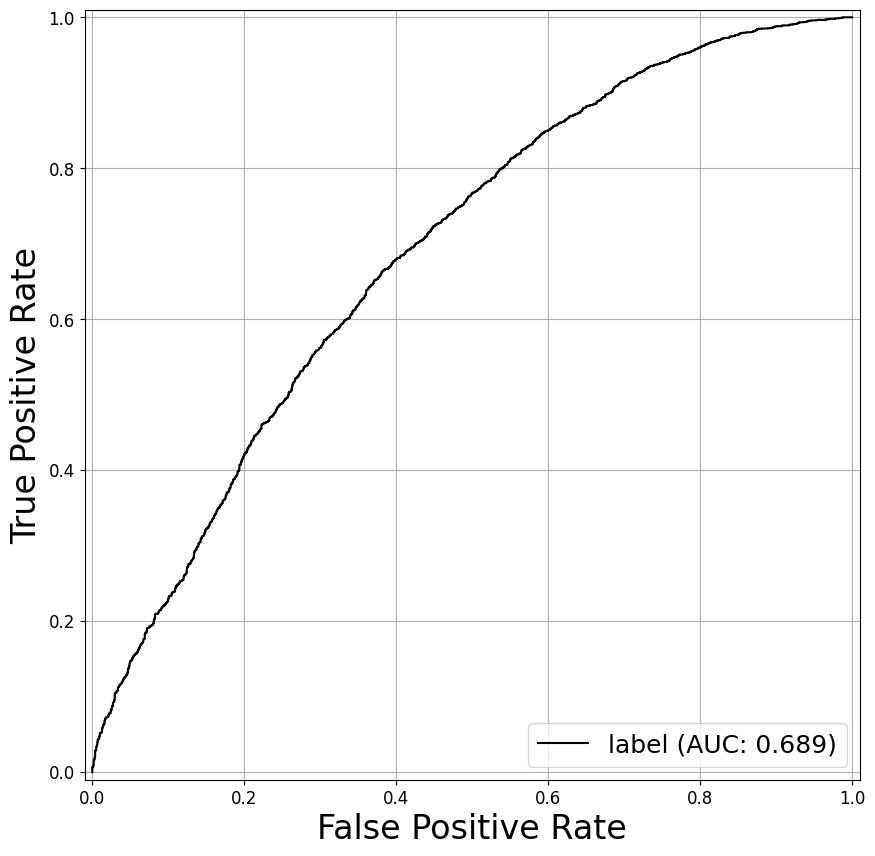

In [ ]:
labels = eval_df[f'{DIAGNOSIS}_value'].values
predictions = eval_df[f'{DIAGNOSIS}_prediction'].values
weights = eval_df[f'{DIAGNOSIS}_weight'].values
false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
    labels,
    predictions,
    drop_intermediate=False)
auc = sklearn.metrics.roc_auc_score(labels, predictions, sample_weight=weights)
accuracy = sklearn.metrics.accuracy_score(labels, [x >= 0.5 for x in predictions])
precision = sklearn.metrics.precision_score(labels, [x >= 0.5 for x in predictions])
recall = sklearn.metrics.recall_score(labels, [x >= 0.5 for x in predictions])
f1 = sklearn.metrics.f1_score(labels, [x >= 0.5 for x in predictions])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("f1:", f1)
print('auc:', auc)
print('cm:', sklearn.metrics.confusion_matrix(labels, [x >= 0.5 for x in predictions]))
plot_curve(false_positive_rate, true_positive_rate, auc, x_label='False Positive Rate', y_label='True Positive Rate', label=DIAGNOSIS)


In [ ]:
def specific(pub, name):
  print('\n' + name, end='\n\n')
  pub = pub[['label',	'dicom_id',	'embedding_file',	'split']]
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")
  pub_labels = dict(zip(pub['image_id'], pub[DIAGNOSIS].astype(int)))
  pub_data = (
      get_dataset(file_names, labels=pub_labels).batch(1).cache()
  )
  rows = []
  for embeddings, label, weight in pub_data:
    row = {
        f'{DIAGNOSIS}_prediction': model(embeddings)[DIAGNOSIS].numpy().flatten()[0],
        f'{DIAGNOSIS}_weight': weight.numpy().flatten()[0],
        f'{DIAGNOSIS}_value': label.numpy().flatten()[0]
    }
    rows.append(row)
  eval_df = pd.DataFrame(rows)

  labels = eval_df[f'{DIAGNOSIS}_value'].values
  predictions = eval_df[f'{DIAGNOSIS}_prediction'].values
  weights = eval_df[f'{DIAGNOSIS}_weight'].values
  false_positive_rate, true_positive_rate, thresholds = sklearn.metrics.roc_curve(
      labels,
      predictions,
      drop_intermediate=False)
  accuracy = sklearn.metrics.accuracy_score(labels, [x >= 0.5 for x in predictions])
  precision = sklearn.metrics.precision_score(labels, [x >= 0.5 for x in predictions])
  recall = sklearn.metrics.recall_score(labels, [x >= 0.5 for x in predictions])
  f1 = sklearn.metrics.f1_score(labels, [x >= 0.5 for x in predictions])

  cm = confusion_matrix(labels,  [x >= 0.5 for x in predictions])

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("f1:", f1)
  print("cm:", cm)

  auc = sklearn.metrics.roc_auc_score(labels, predictions, sample_weight=weights)
  print('auc:', auc)

In [ ]:
insure = pd.read_csv('/content/medicaidcare.csv')
insure.rename(columns={'insurance': 'aids'})
df_labels_val = df_labels[df_labels['split'] == 'validate']
df_labels_val = pd.merge(df_labels, insure, how="left", on=["subject_id"])
df_labels_val

,embedding_file,subject_id,study_id,dicom_id,insurance_x,race,label,gender,split,insurance_y
0,files/p10/p10000980/s50985099/6ad03ed1-97ee17e...,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,1.0,BLACK,0,F,train,2
1,files/p10/p10000980/s51967283/943486a3-b3fa9ff...,10000980,51967283,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,1.0,BLACK,0,F,train,2
2,files/p10/p10000980/s54577367/cfb03587-782edf6...,10000980,54577367,cfb03587-782edf6c-1bf392e1-98196cd5-365d69e8,1.0,BLACK,0,F,train,2
3,files/p10/p10000980/s54935705/6ad819bb-bae74eb...,10000980,54935705,6ad819bb-bae74eb9-7b663e90-b8deabd7-57f8054a,1.0,BLACK,0,F,train,2
4,files/p10/p10000980/s54980801/a75a1fbe-802065a...,10000980,54980801,a75a1fbe-802065ad-717eb7c1-e2ce3552-646276a6,1.0,BLACK,0,F,train,2
...,...,...,...,...,...,...,...,...,...,...
23002,files/p13/p13196638/s51956967/76947f29-410884d...,13196638,51956967,76947f29-410884d3-57ee9c25-f4781392-95ecd2e4,1.0,WHITE / CAUCASION,1,M,train,2
23003,files/p13/p13196638/s51956967/dc2f1215-d41959a...,13196638,51956967,dc2f1215-d41959af-0b4f5ae9-fd4480df-4d64625a,1.0,WHITE / CAUCASION,1,M,train,2
23004,files/p13/p13196638/s58056254/7f5a1c4f-4a9666e...,13196638,58056254,7f5a1c4f-4a9666ec-66008f60-16871c71-e69c0247,1.0,WHITE / CAUCASION,1,M,train,2
23005,files/p13/p13196638/s59401220/5dc626b5-c12038f...,13196638,59401220,5dc626b5-c12038f9-b5dea539-bfa56660-97787cef,1.0,WHITE / CAUCASION,1,M,train,2


# insurance break down

In [ ]:
specific(df_labels_val[df_labels_val['insurance_y'] == 1], 'medicaid ')
specific(df_labels_val[df_labels_val['insurance_y'] == 0], 'private ')
specific(df_labels_val[df_labels_val['insurance_y'] == 2], 'medicare ')


medicaid 



<ipython-input-22-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.8202197802197803
Precision: 0.8275862068965517
Recall: 0.8212147134302823
f1: 0.8243881494203521
cm: [[906 200]
 [209 960]]
auc: 0.892868357833545

private 



<ipython-input-22-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.812989921612542
Precision: 0.807787610619469
Recall: 0.8325428675665816
f1: 0.8199784405318002
cm: [[2074  543]
 [ 459 2282]]
auc: 0.89165960449713

medicare 



<ipython-input-22-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.805125536620268
Precision: 0.819448777951118
Recall: 0.8621293358135463
f1: 0.8402474138850379
cm: [[4499 1736]
 [1260 7879]]
auc: 0.8681922509635336


In [ ]:
insure['insurance'].value_counts()

0    103924
2     58560
1     18249
Name: insurance, dtype: int64

In [ ]:
df_labels_val

,embedding_file,subject_id,study_id,dicom_id,insurance_x,race,label,gender,split,insurance_y
0,files/p10/p10000980/s50985099/6ad03ed1-97ee17e...,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,1.0,BLACK,0,F,train,2
1,files/p10/p10000980/s51967283/943486a3-b3fa9ff...,10000980,51967283,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,1.0,BLACK,0,F,train,2
2,files/p10/p10000980/s54577367/cfb03587-782edf6...,10000980,54577367,cfb03587-782edf6c-1bf392e1-98196cd5-365d69e8,1.0,BLACK,0,F,train,2
3,files/p10/p10000980/s54935705/6ad819bb-bae74eb...,10000980,54935705,6ad819bb-bae74eb9-7b663e90-b8deabd7-57f8054a,1.0,BLACK,0,F,train,2
4,files/p10/p10000980/s54980801/a75a1fbe-802065a...,10000980,54980801,a75a1fbe-802065ad-717eb7c1-e2ce3552-646276a6,1.0,BLACK,0,F,train,2
...,...,...,...,...,...,...,...,...,...,...
23002,files/p13/p13196638/s51956967/76947f29-410884d...,13196638,51956967,76947f29-410884d3-57ee9c25-f4781392-95ecd2e4,1.0,WHITE / CAUCASION,1,M,train,2
23003,files/p13/p13196638/s51956967/dc2f1215-d41959a...,13196638,51956967,dc2f1215-d41959af-0b4f5ae9-fd4480df-4d64625a,1.0,WHITE / CAUCASION,1,M,train,2
23004,files/p13/p13196638/s58056254/7f5a1c4f-4a9666e...,13196638,58056254,7f5a1c4f-4a9666ec-66008f60-16871c71-e69c0247,1.0,WHITE / CAUCASION,1,M,train,2
23005,files/p13/p13196638/s59401220/5dc626b5-c12038f...,13196638,59401220,5dc626b5-c12038f9-b5dea539-bfa56660-97787cef,1.0,WHITE / CAUCASION,1,M,train,2


In [ ]:
specific(df_labels_val[df_labels_val['insurance'] == 1], 'public insurance ')
specific(df_labels_val[df_labels_val['insurance'] == 0], 'private insurance ')


public insurance 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.6417344173441735
Precision: 0.7270754205100379
Recall: 0.6206577119036591
f1: 0.6696651674162918
cm: [[1028  503]
 [ 819 1340]]
auc: 0.7092447001584363

private insurance 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.641804788213628
Precision: 0.6625916870415648
Recall: 0.5191570881226054
f1: 0.5821697099892589
cm: [[426 138]
 [251 271]]
auc: 0.7001542077660934


In [ ]:
# gender 0 = F, 1 = M
#df_labels_val['gender'] = df_labels_val['gender'].map({'F': 0, 'M' : 1})
df_labels_val

,embedding_file,subject_id,study_id,dicom_id,insurance,race,label,gender,split
0,files/p10/p10000980/s50985099/6ad03ed1-97ee17e...,10000980,50985099,6ad03ed1-97ee17ee-9cf8b320-f7011003-cd93b42d,1.0,BLACK,0,0,validate
1,files/p10/p10000980/s51967283/943486a3-b3fa9ff...,10000980,51967283,943486a3-b3fa9ff7-50f5a769-7a62fcbb-f39b6da4,1.0,BLACK,0,0,validate
2,files/p10/p10000980/s54577367/cfb03587-782edf6...,10000980,54577367,cfb03587-782edf6c-1bf392e1-98196cd5-365d69e8,1.0,BLACK,0,0,validate
3,files/p10/p10000980/s54935705/6ad819bb-bae74eb...,10000980,54935705,6ad819bb-bae74eb9-7b663e90-b8deabd7-57f8054a,1.0,BLACK,0,0,validate
4,files/p10/p10000980/s54980801/a75a1fbe-802065a...,10000980,54980801,a75a1fbe-802065ad-717eb7c1-e2ce3552-646276a6,1.0,BLACK,0,0,validate
...,...,...,...,...,...,...,...,...,...
22975,files/p13/p13194166/s56817544/f4b474b7-0fb4920...,13194166,56817544,f4b474b7-0fb49204-e2c9465d-16f1cbbe-a472a698,1.0,BLACK,1,0,validate
22976,files/p13/p13194166/s57045795/19cdd6d3-a51b117...,13194166,57045795,19cdd6d3-a51b117c-c195fd53-39a09c33-cbc5a317,1.0,BLACK,1,0,validate
22977,files/p13/p13194166/s57549650/b2054cd5-e5a00d6...,13194166,57549650,b2054cd5-e5a00d6a-3f42142f-c6a6b6be-3407196f,1.0,BLACK,1,0,validate
22978,files/p13/p13194166/s59843087/a4d185e7-8478f1c...,13194166,59843087,a4d185e7-8478f1c7-23dd9c49-c4377597-71339ed2,1.0,BLACK,1,0,validate


In [ ]:
specific(df_labels_val[df_labels_val['gender'] == 0], 'fems ')
specific(df_labels_val[df_labels_val['gender'] == 1], 'mascs')


fems 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.6381700554528651
Precision: 0.7564766839378239
Recall: 0.6924119241192412
f1: 0.7230279448178282
cm: [[ 359  329]
 [ 454 1022]]
auc: 0.6584893174513141

mascs



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.6447166921898928
Precision: 0.6537180910099889
Recall: 0.4887966804979253
f1: 0.5593542260208927
cm: [[1095  312]
 [ 616  589]]
auc: 0.7047465694644737


In [ ]:
df_labels_val['race'].unique()

array(['BLACK', 'ASIAN', 'WHITE / CAUCASION', 'UNKNOWN', 'OTHER',
       'HISPANIC / LATINO', 'AMERICAN INDIAN / ALASKA NATIVE'],
      dtype=object)

In [ ]:
specific(df_labels_val[df_labels_val['race'] == 'BLACK'], 'BLACK ')
specific(df_labels_val[df_labels_val['race'] == 'ASIAN'], 'ASIAN ')
specific(df_labels_val[df_labels_val['race'] == 'WHITE / CAUCASION'], 'WHITE / CAUCASION ')
specific(df_labels_val[df_labels_val['race'] == 'UNKNOWN'], 'UNKNOWN ')
specific(df_labels_val[df_labels_val['race'] == 'OTHER'], 'OTHER ')
specific(df_labels_val[df_labels_val['race'] == 'HISPANIC / LATINO'], 'HISPANIC / LATINO ')


BLACK 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.7116912599318955
Precision: 0.7218390804597701
Recall: 0.7024608501118568
f1: 0.7120181405895691
cm: [[313 121]
 [133 314]]
auc: 0.780508046474706

ASIAN 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.5263157894736842
Precision: 0.868421052631579
Recall: 0.515625
f1: 0.6470588235294118
cm: [[ 7  5]
 [31 33]]
auc: 0.6692708333333333

WHITE / CAUCASION 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.6262236725007416
Precision: 0.7128526645768025
Recall: 0.5863847343991748
f1: 0.6434634974533107
cm: [[ 974  458]
 [ 802 1137]]
auc: 0.6916325007707134

UNKNOWN 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.5227272727272727
Precision: 0.5526315789473685
Recall: 0.45652173913043476
f1: 0.5
cm: [[25 17]
 [25 21]]
auc: 0.5269151138716356

OTHER 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.6066666666666667
Precision: 0.43137254901960786
Recall: 0.4230769230769231
f1: 0.4271844660194175
cm: [[69 29]
 [30 22]]
auc: 0.6018445839874411

HISPANIC / LATINO 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.736318407960199
Precision: 0.8817204301075269
Recall: 0.6612903225806451
f1: 0.7557603686635945
cm: [[66 11]
 [42 82]]
auc: 0.8069752827817344


In [ ]:
specific(df_labels_val[df_labels_val['race'] == 'AMERICAN INDIAN / ALASKA NATIVE'], 'AMERICAN INDIAN / ALASKA NATIVE ')


AMERICAN INDIAN / ALASKA NATIVE 



<ipython-input-44-5fed7134e089>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pub['image_id'] = pub['embedding_file'].apply(lambda x: f"gs://superrad/inputs/mimic-cxr/{x.replace('tfrecord', 'dcm')}")


Accuracy: 0.2222222222222222
Precision: 1.0
Recall: 0.2222222222222222
f1: 0.3636363636363636
cm: [[0 0]
 [7 2]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


ValueError: ignored